# Capstone: Exploratory Data Analysis

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import project utils
import sys
sys.path.append('../src')

# import constants
import graph_utils


## The Data: San Francisco Police Department Incident Reports

## Read the data

The dataset is available as two CSV files with historical data from 2003-2018 and 2018-Present:

* [San Franciso Police Department Incident Reports: Historical 2003 to May 2018](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry/about_data)
* [Police Department Incident Reports: 2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)

The current data is updated nightly and it takes a few minutes to read and convert the data to a time-series format. So, I've created a set of utilities to optimize data ingestion in the `data_utils.py`.

In [6]:
import data_utils

# Also load the config globals
from data_utils import Config

I periodically refresh the dataset from the [excellent DataSF site](https://www.sf.gov/departments/city-administrator/datasf) to the project `data` directoty, and generate a _clean_ input file transformed as a time-series. I will typically do this a couple of times a week, and save the output as a static comment below so I know what happened.

**Capstone Project 20.1: Initial Report and Exploratory Data Analysis (EDA)**: I'm limiting the report to only the current data for now:

* [Police Department Incident Reports: 2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)


In [8]:
# Convert the raw SFPD data into a cleansed data file - only to be used when refreshing from new data

current_raw_file = Config.CURR_RAW_FILE
current_clean_file = Config.CURR_CLEAN_FILE

# Uncomment to regenerate the clean data file from raw data - normally just read the clean data as it's MUCH FASTER
# data_utils.generate_clean_csv(current_raw_file, current_clean_file, debug=True)

STATIC COMMENT: OUTPUT SAVED FROM LAST SUCCESSFULL RUN (see timestamp below):
```
Start Time: 09/16/24 21:44:49

Reading file: ../data/Police_Department_Incident_Reports__2018_to_Present_20240910.csv ... Done: 887,173 rows, 35 columns
... Formatting column names ... Done
... Creating timeseries columns: datetime ... 
...... Number of rows where the datetime conversion failed: 0
...... Timespan: 2018-01-01 00:00:00 - 2024-09-08 19:30:00
... Done
... Setting index to datetime ... Done

Current Time: 09/16/24 21:46:18

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 887173 entries, 2023-03-13 23:41:00 to 2023-03-21 17:42:00
Data columns (total 35 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   incident_datetime                                     887173 non-null  object 
 1   incident_date                                         887173 non-null  object 
 2   incident_time                                         887173 non-null  object 
 3   incident_year                                         887173 non-null  int64  
 4   incident_day_of_week                                  887173 non-null  object 
 5   report_datetime                                       887173 non-null  object 
 6   row_id                                                887173 non-null  int64  
 7   incident_id                                           887173 non-null  int64  
 8   incident_number                                       887173 non-null  int64  
 9   cad_number                                            689019 non-null  float64
 10  report_type_code                                      887173 non-null  object 
 11  report_type_description                               887173 non-null  object 
 12  filed_online                                          175483 non-null  object 
 13  incident_code                                         887173 non-null  int64  
 14  incident_category                                     886295 non-null  object 
 15  incident_subcategory                                  886295 non-null  object 
 16  incident_description                                  887173 non-null  object 
 17  resolution                                            887173 non-null  object 
 18  intersection                                          838341 non-null  object 
 19  cnn                                                   838341 non-null  float64
 20  police_district                                       887173 non-null  object 
 21  analysis_neighborhood                                 838173 non-null  object 
 22  supervisor_district                                   837885 non-null  float64
 23  supervisor_district_2012                              838198 non-null  float64
 24  latitude                                              838341 non-null  float64
 25  longitude                                             838341 non-null  float64
 26  point                                                 838341 non-null  object 
 27  neighborhoods                                         821671 non-null  float64
 28  esncag_-_boundary_file                                9413 non-null    float64
 29  central_market/tenderloin_boundary_polygon_-_updated  117048 non-null  float64
 30  civic_center_harm_reduction_project_boundary          114781 non-null  float64
 31  hsoc_zones_as_of_2018-06-05                           185157 non-null  float64
 32  invest_in_neighborhoods_(iin)_areas                   0 non-null       float64
 33  current_supervisor_districts                          838198 non-null  float64
 34  current_police_districts                              837437 non-null  float64
dtypes: float64(14), int64(5), object(16)
memory usage: 243.7+ MB
... Writing file: ../data/incidents_clean.csv (887173, 35) ... Done
Done

End Time: 09/16/24 21:46:48
```

As you can see, there are almost a million samples since 2018!

So, I then generate a few randomly sampled datasets of known percentages, to speed up the data exploration. Again only done when refreshing the dataset. Since we'll be working across multiple randomly selected datafiles, I set a global random_state value from hereon remove any randomization artifacts from one run to the next:

In [11]:
# Consistent random_state for the project
print(f'Project-wide random_state: {Config.RANDOM_STATE}')

Project-wide random_state: 42


In [12]:
# Uncomment to generate the sample files

# data_utils.generate_sample_files(current_clean_file, random_state=Config.RANDOM_STATE)

STATIC COMMENT: OUTPUT SAVED FROM LAST SUCCESSFULL RUN (see timestamp below):
```
Start Time: 09/16/24 21:46:49

Reading file: ../data/incidents_clean.csv ... Done: 887,173 rows, 36 columns
... Writing 10% sample file: ../data/incidents_clean_10_pct.csv (88717, 36) ... Done
... Writing 25% sample file: ../data/incidents_clean_25_pct.csv (221793, 36) ... Done
... Writing 50% sample file: ../data/incidents_clean_50_pct.csv (443586, 36) ... Done
... Writing 75% sample file: ../data/incidents_clean_75_pct.csv (665380, 36) ... Done
End Time: 09/16/24 21:48:22
```

In [14]:
# Which dataset to work from?

sample_file = data_utils.select_sample_csv_file(pct=10)
print(f'Selected sample file: {sample_file}')

Selected sample file: ../data/incidents_clean_10_pct.csv


## Preprocessing

### Read in the current data

I use the `get_clean_data_from_csv` function to read the selected sample file:

* Extracts the `datetime` column, converts it to datetime format and sets it as the index for the returned data
* Also copies the `datetime` in a new column `date`

In [18]:
current_raw_df, current_clean_df = data_utils.get_clean_data_from_csv(sample_file)

Reading file: ../data/incidents_clean_10_pct.csv ... Done: 88,717 rows, 37 columns
... Converting datetime to timeseries ... Done
... Setting index to datetime ... Done
Done


In [19]:
print(f'Dataset Sizes: CurrentRaw: {current_raw_df.shape}, Current_Clean: {current_clean_df.shape}')

Dataset Sizes: CurrentRaw: (88717, 36), Current_Clean: (88717, 36)


In [20]:
current_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88717 entries, 2022-02-10 07:59:00 to 2021-07-09 00:22:00
Data columns (total 36 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            88717 non-null  int64  
 1   incident_datetime                                     88717 non-null  object 
 2   incident_date                                         88717 non-null  object 
 3   incident_time                                         88717 non-null  object 
 4   incident_year                                         88717 non-null  int64  
 5   incident_day_of_week                                  88717 non-null  object 
 6   report_datetime                                       88717 non-null  object 
 7   row_id                                                88717 non-null  int64  
 8   incident_id          

### Inspect: Nulls

In [22]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_raw_df.isnull().sum().transform(lambda x: (1 - (x / current_raw_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


Unnamed: 0                                              100.00
incident_datetime                                       100.00
incident_date                                           100.00
incident_time                                           100.00
incident_year                                           100.00
incident_day_of_week                                    100.00
report_datetime                                         100.00
row_id                                                  100.00
incident_id                                             100.00
incident_number                                         100.00
cad_number                                               77.73
report_type_code                                        100.00
report_type_description                                 100.00
filed_online                                             19.77
incident_code                                           100.00
incident_category                                      

#### Remove unwanted columns

We now have the current data in two dataframes - _we will keep the `current_raw_df` data pristine and start pre-processing 
the `current_clean_df` as we analyze the content_.

Let's take a first pass at removing unwanted columns.

Detailed descriptions can be found in two main sources that explain the data fields in the dataset:

* [DataSF Data Sheet](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)
* [DataSF | Dataset Explainers: SFPD Incident Report: 2018 to Present](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present)

In [25]:
current_raw_df.columns

Index(['Unnamed: 0', 'incident_datetime', 'incident_date', 'incident_time',
       'incident_year', 'incident_day_of_week', 'report_datetime', 'row_id',
       'incident_id', 'incident_number', 'cad_number', 'report_type_code',
       'report_type_description', 'filed_online', 'incident_code',
       'incident_category', 'incident_subcategory', 'incident_description',
       'resolution', 'intersection', 'cnn', 'police_district',
       'analysis_neighborhood', 'supervisor_district',
       'supervisor_district_2012', 'latitude', 'longitude', 'point',
       'neighborhoods', 'esncag_-_boundary_file',
       'central_market/tenderloin_boundary_polygon_-_updated',
       'civic_center_harm_reduction_project_boundary',
       'hsoc_zones_as_of_2018-06-05', 'invest_in_neighborhoods_(iin)_areas',
       'current_supervisor_districts', 'current_police_districts'],
      dtype='object')

During the first pass, we'll use the following strategy to drop the initial set of columns:

* Columns named `Unnamed: nnn`: these were introduced during the sample file generation and are unwanted
* Columns that are mostly empty
  * esncag_-_boundary_file
  * central_market/tenderloin_boundary_polygon_-_updated
  * civic_center_harm_reduction_project_boundary
  * hsoc_zones_as_of_2018-06-05
  * invest_in_neighborhoods_(iin)_areas
* Any administrative columns that are not related to predicting the crime category from its related features:
  * report_type_code
  * report_type_description
  * filed_online
* Columns that identify street or address information that we will not be using as we are focused on predictions based on LatLong, neighborhood or Police District and Precinct
  * intersection
  * cnn
  * Point: Redundant since we have latitude, longitude
* Columns that have to do with City governance and not related to crime prediction
  * supervisor_district
  * supervisor_district_2012
  * current_supervisor_districts


In [27]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [28]:
# Commented out analysis for unwanted columns above

# current_raw_df.groupby(['intersection', 'cnn'])['intersection'].count()
# current_raw_df.groupby(['report_type_description', 'report_type_code'])['report_type_description'].count()
# current_raw_df.groupby(['supervisor_district', 'supervisor_district_2012'])['supervisor_district'].count()
# current_raw_df.groupby(['supervisor_district', 'current_supervisor_districts'])['supervisor_district'].count()
# current_raw_df.groupby(['report_type_description', 'report_type_code'])['report_type_description'].count()
# current_raw_df.groupby(['analysis_neighborhood', 'neighborhoods'])['analysis_neighborhood'].count()

In [29]:
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [30]:
drop_cols_unwanted = ['Unnamed: 0', 
                      'esncag_-_boundary_file', 'central_market/tenderloin_boundary_polygon_-_updated',  
                      'civic_center_harm_reduction_project_boundary','hsoc_zones_as_of_2018-06-05',
                      'invest_in_neighborhoods_(iin)_areas',
                      'report_type_code', 'report_type_description', 'filed_online',
                      'intersection', 'cnn', 'point',
                      'supervisor_district', 'supervisor_district_2012', 'current_supervisor_districts',
                     ]

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_unwanted)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 dropped
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
... preprocess_drop_cols: Column current_supervisor_d

In [31]:
current_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88717 entries, 2022-02-10 07:59:00 to 2021-07-09 00:22:00
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   incident_datetime         88717 non-null  object 
 1   incident_date             88717 non-null  object 
 2   incident_time             88717 non-null  object 
 3   incident_year             88717 non-null  int64  
 4   incident_day_of_week      88717 non-null  object 
 5   report_datetime           88717 non-null  object 
 6   row_id                    88717 non-null  int64  
 7   incident_id               88717 non-null  int64  
 8   incident_number           88717 non-null  int64  
 9   cad_number                68957 non-null  float64
 10  incident_code             88717 non-null  int64  
 11  incident_category         88624 non-null  object 
 12  incident_subcategory      88624 non-null  object 
 13  incident_description      

In [32]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


incident_datetime           100.00
incident_date               100.00
incident_time               100.00
incident_year               100.00
incident_day_of_week        100.00
report_datetime             100.00
row_id                      100.00
incident_id                 100.00
incident_number             100.00
cad_number                   77.73
incident_code               100.00
incident_category            99.90
incident_subcategory         99.90
incident_description        100.00
resolution                  100.00
police_district             100.00
analysis_neighborhood        94.50
latitude                     94.52
longitude                    94.52
neighborhoods                92.70
current_police_districts     94.40
dtype: float64

Most of the columns have above 90% non-null data. We can move onto analyzing individual features now.

In [34]:
current_clean_df.head(3).T

datetime,2022-02-10 07:59:00,2022-11-17 23:30:00,2023-12-23 22:50:00
incident_datetime,2022/02/10 07:59:00 AM,2022/11/17 11:30:00 PM,2023/12/23 10:50:00 PM
incident_date,2022/02/10,2022/11/17,2023/12/23
incident_time,07:59,23:30,22:50
incident_year,2022,2022,2023
incident_day_of_week,Thursday,Thursday,Saturday
report_datetime,2022/02/10 08:10:00 AM,2022/11/19 03:23:00 PM,2023/12/23 11:17:00 PM
row_id,112051707041,121645375000,135012372000
incident_id,1120517,1216453,1350123
incident_number,220024353,220797237,230896528
cad_number,220410553.0,223232034.0,233572750.0


### Inspect: Time-based Features

#### Inspect: Incidents per Day

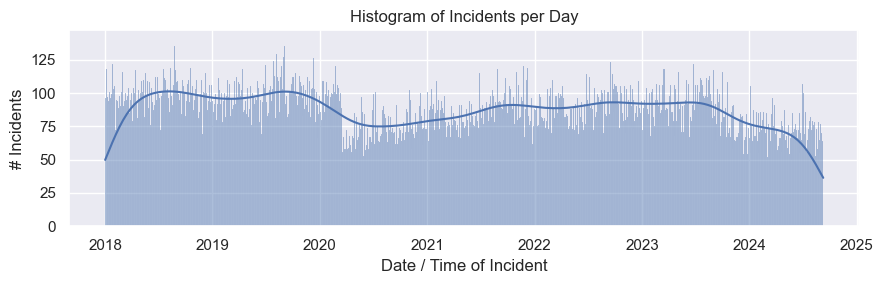

Total of 88,717 incidents from 2018-01-01 00:00:00 to 2024-09-08 16:26:00


In [37]:
plt.figure(figsize=(graph_utils.page_width, 3))
sns.histplot(data=current_clean_df, x=current_clean_df.index, bins=1000, kde=True)
# sns.histplot(data=current_clean_df, x=current_clean_df.index, discrete=True, kde=True)

plt.xlabel('Date / Time of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents per Day')

plt.tight_layout()
plt.savefig('../images/incidents_per_day.png')
plt.show()

print(f'Total of {current_clean_df.shape[0]:,d} incidents from {current_clean_df.index.min()} to {current_clean_df.index.max()}')

#### Inspect: Incidents per Year

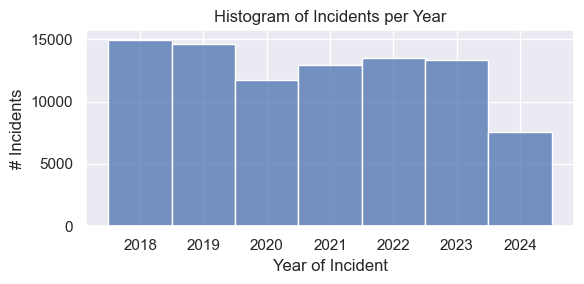

In [39]:
plt.figure(figsize=(6, 3))
# sns.histplot(data=current_clean_df, x='incident_year', kde=True)
sns.histplot(data=current_clean_df, x='incident_year', discrete=True)

plt.xlabel('Year of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents per Year')

plt.tight_layout()
plt.savefig('../images/incidents_per_year.png')
plt.show()

#### Inspect: Incidents by Day of Week

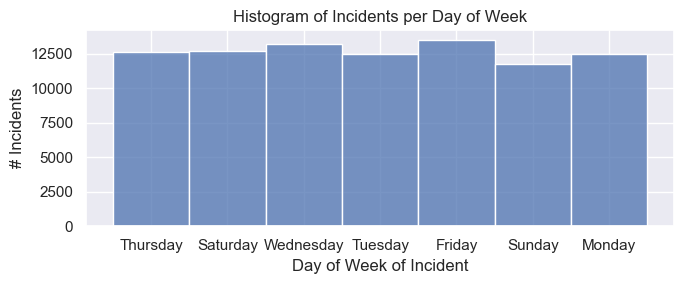

In [41]:
plt.figure(figsize=(7, 3))
# sns.histplot(data=current_clean_df, x='incident_year', kde=True)
sns.histplot(data=current_clean_df, x='incident_day_of_week')#, discreet=False)

plt.xlabel('Day of Week of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents per Day of Week')

plt.tight_layout()
plt.savefig('../images/incidents_per_DoW.png')
plt.show()

In [42]:
current_clean_df.columns

Index(['incident_datetime', 'incident_date', 'incident_time', 'incident_year',
       'incident_day_of_week', 'report_datetime', 'row_id', 'incident_id',
       'incident_number', 'cad_number', 'incident_code', 'incident_category',
       'incident_subcategory', 'incident_description', 'resolution',
       'police_district', 'analysis_neighborhood', 'latitude', 'longitude',
       'neighborhoods', 'current_police_districts'],
      dtype='object')

### Inspect: Incident-Specific Features

Let's look at Incident-specific features that are left for a specific Incident to understand how the data is reported:
  * incident_datetime
  * report_datetime
  * row_id
  * incident_id / incident_code
  * incident_number
  * cad_number
  * incident_category
  * incident_subcategory
  * incident_description
  * resolution

Is there an interesting incident to look at with a lot of rows?

In [45]:
inc_id = current_clean_df[current_clean_df.incident_id.duplicated()].incident_id.value_counts().index[0]

In [46]:
current_raw_df.query('incident_id == @inc_id')[['incident_datetime', 'report_datetime', 'incident_id', 'incident_code', 
                                                'row_id', 'incident_number', 'cad_number',
                                                'incident_category','incident_subcategory', 'incident_description', 
                                                'resolution']]

,incident_datetime,report_datetime,incident_id,incident_code,row_id,incident_number,cad_number,incident_category,incident_subcategory,incident_description,resolution
datetime,,,,,,,,,,,
2023-09-08 09:45:00,2023/09/08 09:45:00 AM,2023/09/08 11:53:00 AM,1316448,28160,131644828160,230643294,232511421.0,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Vehicle",Open or Active
2023-09-08 09:45:00,2023/09/08 09:45:00 AM,2023/09/08 11:53:00 AM,1316448,15200,131644815200,230643294,232511421.0,Offences Against The Family And Children,Other,Domestic Violence (secondary only),Open or Active
2023-09-08 09:45:00,2023/09/08 09:45:00 AM,2023/09/08 11:53:00 AM,1316448,4013,131644804013,230643294,232511421.0,Assault,Aggravated Assault,"Assault, Aggravated, W/ Other Weapon",Open or Active


The single incident, multiple rows explanation is as follows (from the [DataSF Dataset Explainer](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present#multiple-incident-codes)):

>Incident reports can have one or more associated Incident Codes. For example, an officer may have a warrant for an
>arrest and while making the arrest, discovers narcotics in the individual’s possession. The officer would record
>two Incident Codes: (1) for the warrant and (2) for the discovery of narcotics.
>
>When multiple Incident Codes exist, the Incident ID, Incident Number and CAD Numbers remain the same and the
>Row ID field can be used as a unique identifier for each row of data. An example is provided below.

Since we are interested in predicting the `incident_category` based on time and location, we'll retain  all three rows, each with a different category, but remove the columns that merge them into a single incident. This gives us more training data with a whetted outcome, i.e. target variable.

So we will drop the following columns:

  * incident_datetime / report_datetime
  * incident_id / incident_code / row_id / incident_number / cad_number
  * incident_subcategory
  * incident_description

and only retain `incident_category` as our target variable - we will look at `resolution` separately.

In [48]:
drop_cols_incident = ['incident_datetime', 'report_datetime', 
                      'incident_id', 'incident_code', 'row_id', 'incident_number', 'cad_number',
                      'incident_subcategory', 'incident_description'
                     ]

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_incident)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column incident_datetime dropped
... preprocess_drop_cols: Column report_datetime dropped
... preprocess_drop_cols: Column incident_id dropped
... preprocess_drop_cols: Column incident_code dropped
... preprocess_drop_cols: Column row_id dropped
... preprocess_drop_cols: Column incident_number dropped
... preprocess_drop_cols: Column cad_number dropped
... preprocess_drop_cols: Column incident_subcategory dropped
... preprocess_drop_cols: Column incident_description dropped
... Done


#### Inspect: Resolution

In [50]:
current_clean_df.resolution.value_counts()

resolution
Open or Active          71297
Cite or Arrest Adult    16737
Unfounded                 444
Exceptional Adult         239
Name: count, dtype: int64

Both the `Unfounded` and `Exceptional Adult` resolution types will dismiss the case so we can remove these rows.

In [52]:
current_clean_df = current_clean_df.query('resolution != "Unfounded" and resolution != "Exceptional Adult"')

In [53]:
current_clean_df.resolution.value_counts()

resolution
Open or Active          71297
Cite or Arrest Adult    16737
Name: count, dtype: int64

In [54]:
# graph_utils.graph_features(current_clean_df, 13, 2, figsize=(10, 15))

#### Inspect: Police Districts

In [56]:
current_clean_df.police_district.value_counts()

police_district
Central       12908
Northern      11957
Mission       11031
Southern      10423
Tenderloin     8765
Bayview        7750
Ingleside      6949
Taraval        6268
Richmond       5348
Park           3924
Out of SF      2711
Name: count, dtype: int64

In [57]:
current_clean_df.current_police_districts.value_counts()

current_police_districts
6.0     12344
4.0     11889
3.0     10867
1.0     10448
5.0      8212
2.0      7785
9.0      6739
10.0     6435
8.0      4631
7.0      3730
Name: count, dtype: int64

We can safely drop the `current_police_districts` column as it's not very useful, we can use `police_district` 
as a categorical feature instead. However, we need to remove the incidents that are `Out of SF`.

In [59]:
current_clean_df = current_clean_df.query('police_district != "Out of SF"')

In [60]:
current_clean_df.police_district.value_counts()

police_district
Central       12908
Northern      11957
Mission       11031
Southern      10423
Tenderloin     8765
Bayview        7750
Ingleside      6949
Taraval        6268
Richmond       5348
Park           3924
Name: count, dtype: int64

In [61]:
drop_cols_pd = ['current_police_districts']

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_pd)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column current_police_districts dropped
... Done


Now that we have fewer features, I will now rename the incident-specific columns to make it easier to understand our features:

In [63]:
current_clean_df = current_clean_df.rename(columns={'incident_date':'date',
                                                    'incident_time':'time',
                                                    'incident_year':'year',
                                                    'incident_day_of_week':'day_of_week',
                                                    'incident_category':'category'
                                                   })

In [64]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


date                     100.00
time                     100.00
year                     100.00
day_of_week              100.00
category                  99.90
resolution               100.00
police_district          100.00
analysis_neighborhood     96.49
latitude                  96.52
longitude                 96.52
neighborhoods             94.65
dtype: float64

#### Inspect: Neighborhoods

Similar to the police disctricts, we have two redundant columns `neighborhoods` and `analysis_neighborhood`:

In [67]:
current_clean_df.analysis_neighborhood.value_counts()

analysis_neighborhood
Mission                           8912
Tenderloin                        8753
South of Market                   6710
Financial District/South Beach    6483
Bayview Hunters Point             5465
North Beach                       2736
Western Addition                  2638
Sunset/Parkside                   2485
Nob Hill                          2479
Castro/Upper Market               2415
Marina                            2337
Hayes Valley                      2230
Russian Hill                      1945
Outer Richmond                    1789
West of Twin Peaks                1739
Bernal Heights                    1619
Pacific Heights                   1520
Excelsior                         1470
Chinatown                         1394
Potrero Hill                      1351
Haight Ashbury                    1304
Mission Bay                       1290
Outer Mission                     1219
Inner Sunset                      1108
Lone Mountain/USF                 1061
Lak

In [68]:
current_clean_df.neighborhoods.value_counts()

neighborhoods
32.0    7997
53.0    6723
20.0    5444
19.0    2926
21.0    2651
        ... 
63.0      43
2.0       38
69.0      34
70.0      17
7.0       16
Name: count, Length: 116, dtype: int64

We will drop the `neighborhoods` column and re-use it's name for the `analysis_neighborhood` column:

In [70]:
drop_cols_neighborhoods = ['neighborhoods']

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_neighborhoods)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column neighborhoods dropped
... Done


In [71]:
current_clean_df.rename(columns={'analysis_neighborhood':'neighborhood'}, inplace=True)

#### Inspect: Categories - Target Variable

Let's take a look at our target variable `incident_category` to get an understanding of the relationships with the other features.

##### Categories: Histogram

In [75]:
current_clean_df.columns

Index(['date', 'time', 'year', 'day_of_week', 'category', 'resolution',
       'police_district', 'neighborhood', 'latitude', 'longitude'],
      dtype='object')

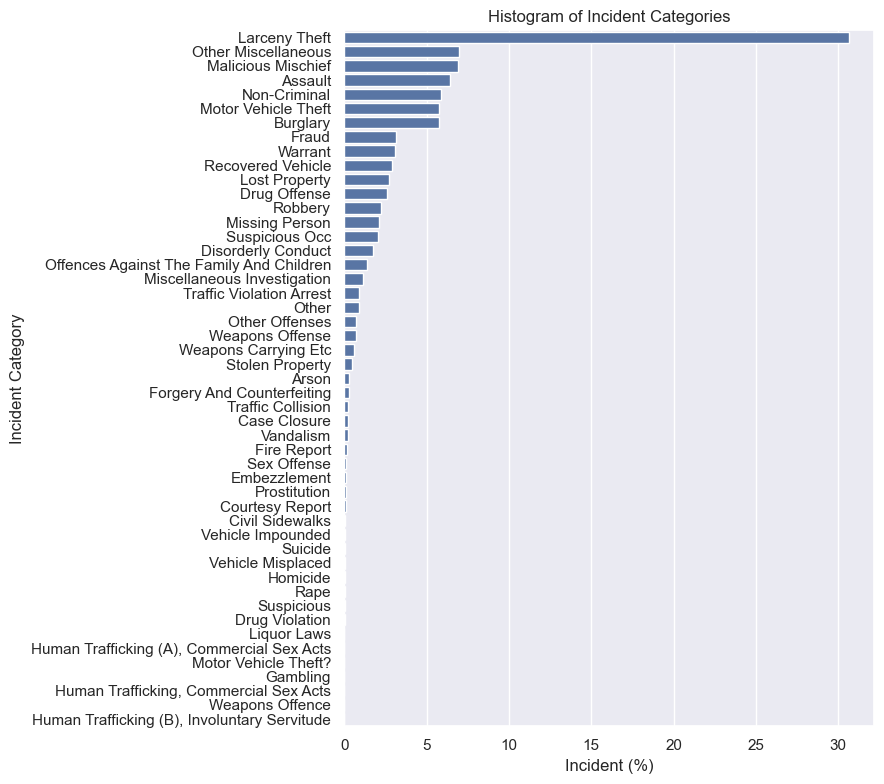

In [76]:
plt.figure(figsize=(graph_utils.page_width, 8))

cats = current_clean_df.category.value_counts()
sns.barplot(cats.transform(lambda x: (x / cats.values.sum()) * 100), orient='h')

plt.xlabel('Incident (%)')
plt.ylabel('Incident Category')
plt.title('Histogram of Incident Categories')

plt.tight_layout()
plt.savefig('../images/incidents_per_day.png')
plt.show()


In [77]:
print(f'Total of {cats.shape[0]:,d} categories\n\nTop-10 by % Incidence:')

cats.head(10)

Total of 49 categories

Top-10 by % Incidence:


category
Larceny Theft          26114
Other Miscellaneous     5945
Malicious Mischief      5910
Assault                 5456
Non-Criminal            5026
Motor Vehicle Theft     4930
Burglary                4904
Fraud                   2674
Warrant                 2640
Recovered Vehicle       2476
Name: count, dtype: int64

##### Categories: By Year

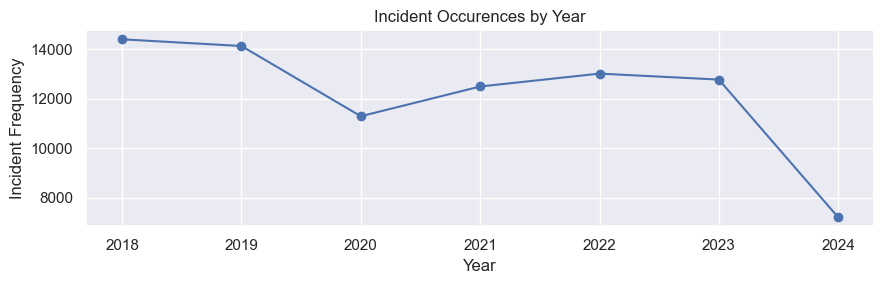

In [79]:
plt.figure(figsize=(graph_utils.page_width, 3))

current_clean_df.year.value_counts().sort_index().plot(marker='o')

plt.xlabel('Year')
plt.ylabel('Incident Frequency')
plt.title('Incident Occurences by Year')

plt.tight_layout()
plt.savefig('../images/incidents_per_year.png')
plt.show()

##### Categories - Top 10: By Year

In [81]:
top_n = 10
top_cats = cats.index[0:top_n]

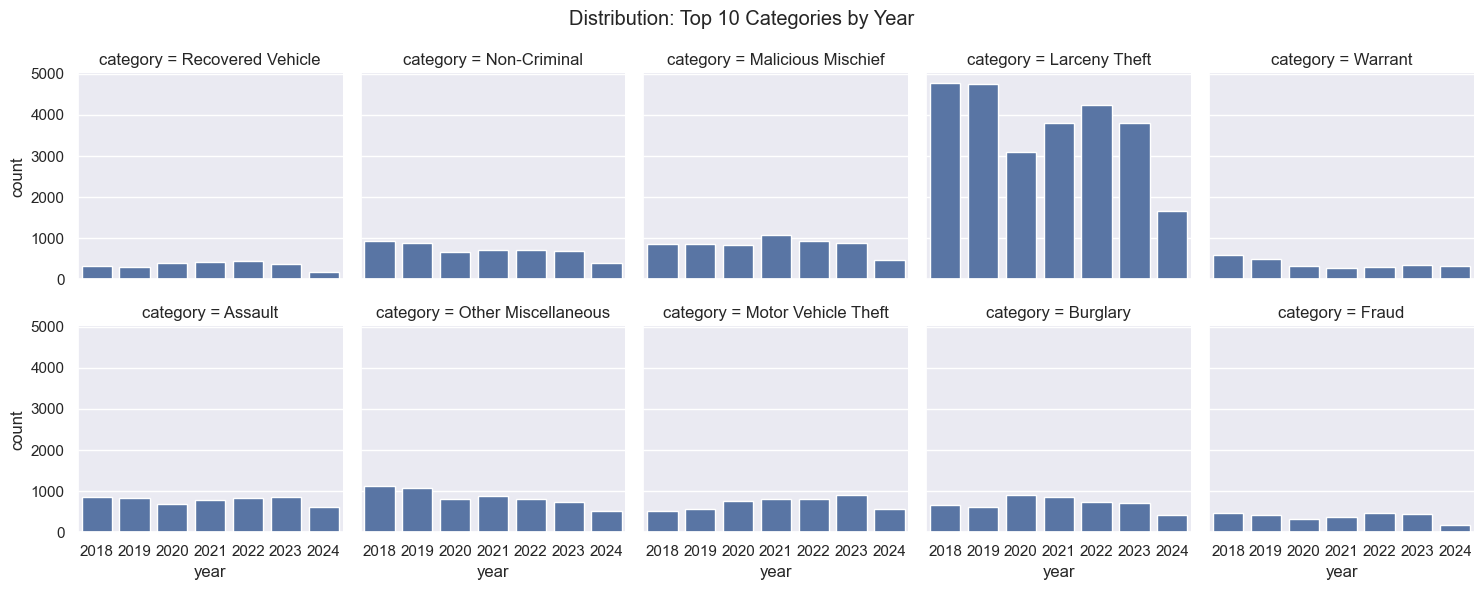

In [82]:
g = sns.FacetGrid(current_clean_df[['category', 'year']].query('category in @top_cats'), 
                  col='category', col_wrap=5)
g = g.map(sns.countplot, 'year', order=np.sort(current_clean_df['year'].unique()))
# g.set_xticklabels(rotation=30)

plt.suptitle(f'Distribution: Top {top_n} Categories by Year')
plt.ylabel('Incidents / Year')
plt.tight_layout()
plt.savefig('../images/incidents_top_n_by_year.png')

plt.show()

##### Categories: By Police Disctrict

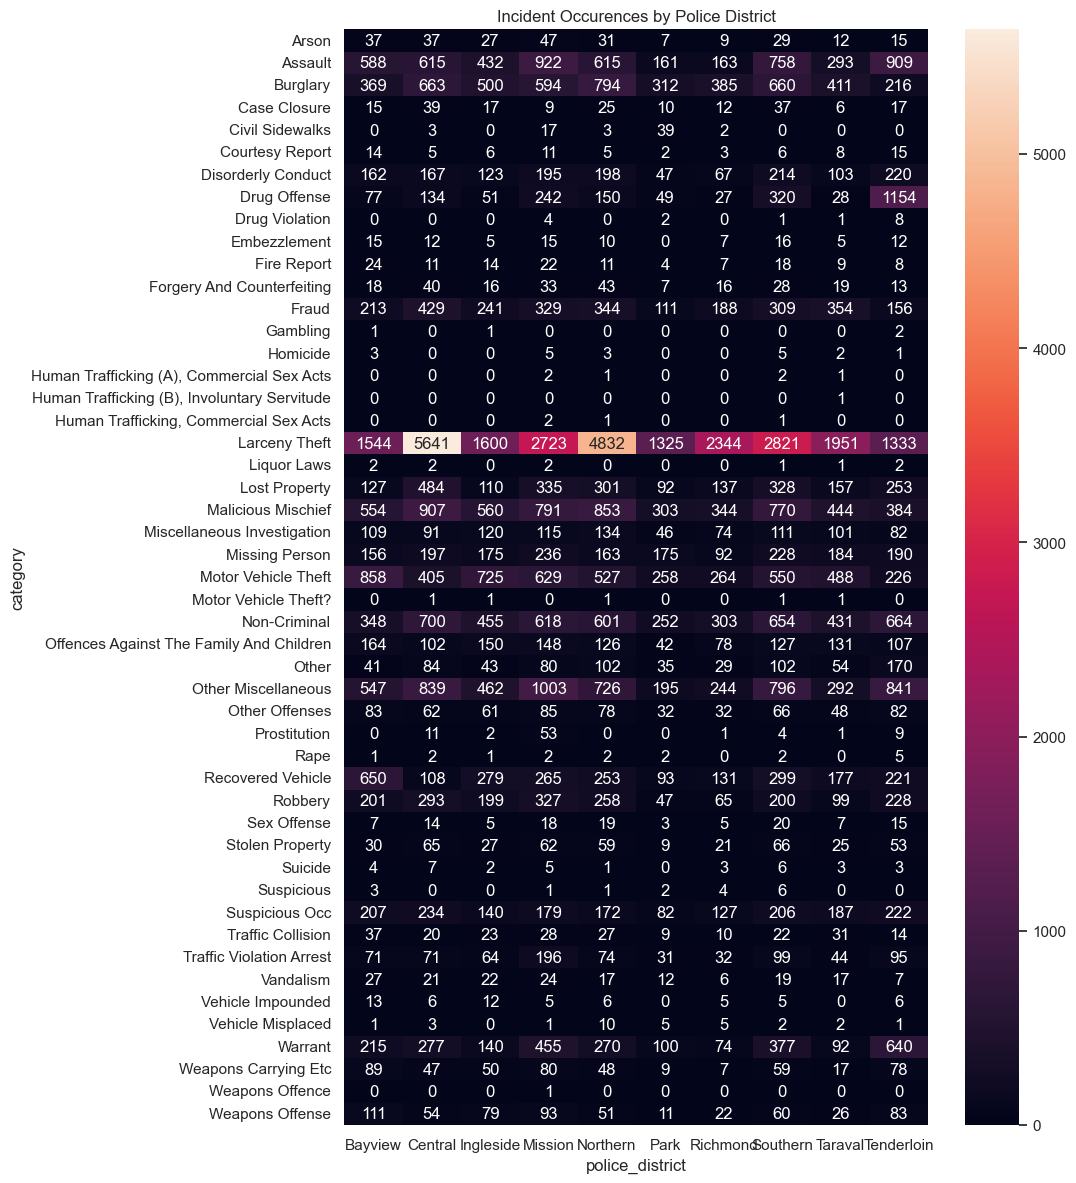

In [84]:
heatmap_data = pd.crosstab(current_clean_df['category'], current_clean_df['police_district'])

plt.figure(figsize=(graph_utils.page_width+2, 12))

sns.heatmap(heatmap_data, annot=True, fmt='d')

# plt.xlabel('Police District')
# plt.ylabel('Category')
plt.title('Incident Occurences by Police District')

plt.tight_layout()
plt.savefig('../images/incidents_per_district_heatmap.png')
plt.show()

#### Drop Nulls

We have now gotten rid of most of the unwanted data and most of the columns have above 94% non-null data. This is sufficient data for training, so we will drop all null rows for now:

In [87]:
current_clean_df.dropna(inplace=True)

In [88]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


date               100.0
time               100.0
year               100.0
day_of_week        100.0
category           100.0
resolution         100.0
police_district    100.0
neighborhood       100.0
latitude           100.0
longitude          100.0
dtype: float64

In [89]:
current_clean_df.head(2)

,date,time,year,day_of_week,category,resolution,police_district,neighborhood,latitude,longitude
datetime,,,,,,,,,,
2022-02-10 07:59:00,2022/02/10,07:59,2022,Thursday,Recovered Vehicle,Open or Active,Ingleside,West of Twin Peaks,37.728975,-122.468077
2022-11-17 23:30:00,2022/11/17,23:30,2022,Thursday,Missing Person,Open or Active,Mission,Mission,37.762579,-122.421662


## Cross-check Preprocessing

Read in the preprocessed data from utility function and validate against the currently _cleaned_ data 
as part of the data investigation

In [92]:
temp = data_utils.preprocess_data(current_raw_df.copy())

crosscheck = 'PASSED' if (temp.shape[0] == current_clean_df.shape[0]
                          and temp.shape[1] == current_clean_df.shape[1]) else 'FAILED'
print('\n\nCROSSCHECK {}: raw: {} -> pre-processed: {} == cleaned: {}\n\n'
      .format(crosscheck, current_raw_df.shape, temp.shape, current_clean_df.shape))

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 dropped
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
... preprocess_drop_cols: Column current_supervisor_d

In [93]:
# for col in zip(temp.columns, current_clean_df.columns):
#     print (col)

We're ready for modeling now!